# Testing Lucy-Richardson Deconvolution for SANS

This notebook is a demo of the simplest kind of deconvolution, Lucy-Richardson.  It was used most famously on the hubble space telescope to remove the blur whilst they waited for a hardware fix to be installed for the mirror problem, back in the 1990s.

It does exist already in some libraries (scikit-image) but the implementation in scikit-image does not make sense for spectral deconvolution in 1D.  Scikit-image assumes a 2D data set and a 2D probability map, for processing blurry images.  In any case, Lucy-Richardson is not that difficult, as you can see below.

First, we need to define a point spread function, which is just a matrix.  This code uses 1/Q for each Q point as an array of bins of correlation lengths or radii (that way, we don't need to explicitly feed in a resolution function, but *we should do that*).  Then for each correlation length we compute the spectral shape.  That way, the measured data d[i] = P[i,j] * e[j] where e[j] are the bins of correlation length and P[i,j] is the point spread function.  So, for example, if the function is a lorentzian, then each row in P[i,j] is a lorentzian with a single Q value and many K values, and each column is a lorentzian with one K value and many Q values.  The matrix is built using the same method as kernel density estimation, except that the points are all on a grid in both directions.

Having generated the point spread matrix, this can then be easily fed into the LR_deconv() function which does it's thing.  This is an exact implementation of the wikipedia description (https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution) but some of the wikipedia page looks iffy to be honest.  There are summation symbols where it should be matrix multiplication as far as I can tell.  The difference here is that I include a normalised chi-squared test to terminate the reconstruction if chi-squared drops below 1.  That way, we prevent over-fitting of the data and the introduction of statistical noise into the estimate.

Note that the exactly the same point spread matrix is used in maximum entropy.  It's identical.  The difference between Lucy-Richardson and max-ent is that LR is a maximum likelihood estimate of the distribution, whilst max-ent is a maximally non-committal estimate of the distribution according to information theory.  Max-ent finds the region where chi-squared = 1 and then finds the edge of that zone whilst increasing entropy.  In theory, the two methods should probably agree with enough data points, but LR is WAAAY easier to code as you can see here, it's like 10 lines of numpy or something.

Lucy-Richardson fit failed to converge after 30 iterations.
x2= 2912.3480882771028


Text(0, 0.5, 'P(r)')

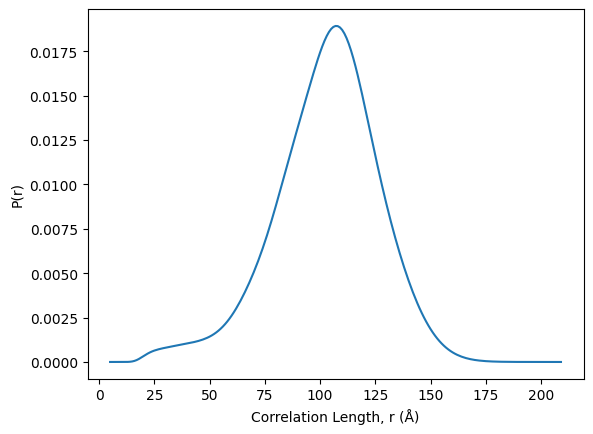

In [79]:
# Lucy Richardson deconvolution tests

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

def lorentzian(qq, kappa):
    lr = (kappa / np.pi) / (np.power(qq, 2.0) + np.power(kappa, 2.0))
    return(lr)

def hardspheres(qq, rr):
    xr = qq * rr
    xr6= xr ** 6.0
    hrd = 15.0 * rr * ( np.sin(xr) - xr * np.cos(xr))**2.0  / (2.0 * np.pi * xr6)
    return hrd

def lorentzianPSF(datax, datay):
    #datax = data[:,0]
    #datay = data[:,1]
    # First figure out range of kappa values
    xrange = np.array( [ np.amin(datax), np.amax(datax) ])
    rrange = 1.0/xrange
    rrange = np.round(np.flip(rrange))
    #print(xrange)
    #print(rrange)
    rvals = np.arange(rrange[0], 2.0*rrange[1], 1.0)
    nx = datax.size
    nr = rvals.size
    
    #print(nx)
    #print(nr)
    
    pmatrix = np.zeros((nx, nr))
    
    for i in range(nx):
        for j in range(nr):
            pmatrix[i,j] = pmatrix[i,j] + lorentzian(datax[i], 1.0/rvals[j])
    return pmatrix, rvals


def spheresPSF(datax, datay):
    #datax = data[:,0]
    #datay = data[:,1]
    # First figure out range of R values
    xrange = np.array( [ np.amin(datax), np.amax(datax) ])
    rrange = 1.0/xrange
    rrange = np.round(np.flip(rrange))
    #print(xrange)
    #print(rrange)
    rvals = np.arange(rrange[0], 2.0*rrange[1], 1.0)
    nx = datax.size
    nr = rvals.size
    
    #print(nx)
    #print(nr)
    
    pmatrix = np.zeros((nx, nr))
    
    for i in range(nx):
        for j in range(nr):
            pmatrix[i,j] = pmatrix[i,j] + hardspheres(datax[i], rvals[j])
    return pmatrix, rvals

def x2(yvals, fity):
    # calculates chi-squared
    diff = yvals-fity
    diff2= diff**2.0
    frac = diff2/fity
    x2 = np.sum(frac)
    return x2

def getfity(uj, psf):
    fity = psf.dot(uj)
    return(fity)

def LR_deconv(datay, psf, niter =100):
    di = datay
    pij = psf
    
    uj = np.ones(psf.shape[1])
    
    #print("di is", di.shape)
    #print("pij is", pij.shape)
    #print("uj is", uj.shape)

    
    uj = uj / uj.size
    
    fity = getfity(uj, psf)
    
    sumf = np.sum(fity)
    sumd = np.sum(yvals)
    fity = fity * sumd/sumf

    
    chisq = x2(yvals, fity)/datay.size
    
    #print("x2=", chisq)
    
    converged = False
    iterdone = 0
    
    for _ in range(niter):
    
        #ci = np.sum(pij.dot(uj))
        ci = pij.dot(uj)
        
        #print("ci:", ci)
    
        dici = (di/ci)
        
        pijt = np.transpose(pij)
    
        mult = pijt.dot(dici)
    
        ujp = uj * mult
        
        uj = np.copy(ujp)
        
        testuj = np.copy(uj)
        testujs= np.sum(testuj)
        testuj = testuj / testujs
        
        fity = getfity(testuj, psf)
        sumf = np.sum(fity)
        sumd = np.sum(yvals)
        fity = fity * sumd/sumf
        
        chisq = x2(yvals, fity) / datay.size
        
        #print("x2=", chisq)
        
        iterdone = iterdone + 1
        
        if(chisq <= 1.0):
            converged = True
            break
        else:
            continue
        
        #print(uj[0])
        
    ujs = np.sum(uj)
    uj = uj / ujs
        
    if converged:
        print("Lucy-Richardson fit converged after", iterdone, "iterations.")
    else:
        print("Lucy-Richardson fit failed to converge after", iterdone, "iterations.")
        print("x2=", chisq)
        
    return uj
    
    


hist = np.genfromtxt('data/SANS/nanodiamonds/digitised.csv', delimiter=',', skip_header=True)

xvals=hist[:,0]
# take only centre portion of the points - avoid some systematics in the histogram and the obvious background
mask = np.arange(0, int(np.round(xvals.size / 10.0)))
xvals = np.delete(xvals, mask)
yvals=hist[:,1]
yvals = np.delete(yvals, mask)

mask = np.full_like(xvals, False)
keep = np.arange(0, int(np.round(xvals.size * 0.5)))
mask[keep] = True
mask = mask.astype(bool)
xvals = xvals[mask]
yvals = yvals[mask]



noisy=yvals

#psf, rvals = lorentzianPSF(hist)
psf, rvals = spheresPSF(xvals, yvals)

#print("Noisy dimensions:", noisy.ndim, "and shape", noisy.shape)
#print("PSF dimensions:", psf.ndim, "and shape", psf.shape)

resto = LR_deconv(noisy, psf, niter=30)

fity = getfity(resto, psf)

dats = np.sum(noisy)
fits = np.sum(fity)
fity = fity * dats/fits

#print(resto)

fig, ax = plt.subplots()
ax.plot(rvals, resto)
ax.set_xlabel("Correlation Length, r (Å)")
ax.set_ylabel("P(r)")

#resto = restoration.richardson_lucy(noisy, psf1d, clip=False, num_iter=10)

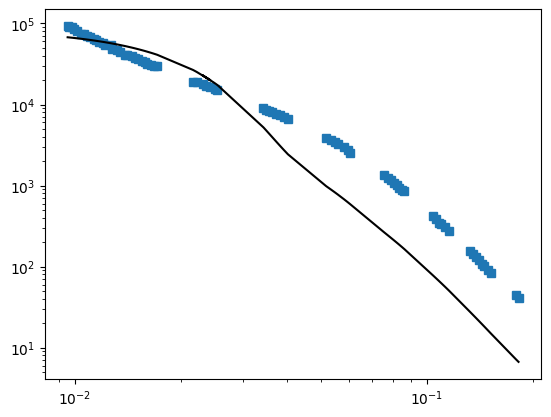

In [120]:


fig, ax = plt.subplots()
ax.plot(xvals, yvals, 's')
ax.plot(xvals, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

Generated 5000 samples using parameters [0.01111111]
Lucy-Richardson fit failed to converge after 50 iterations.
x2= 1.928564210696018


Text(0, 0.5, 'P(r)')

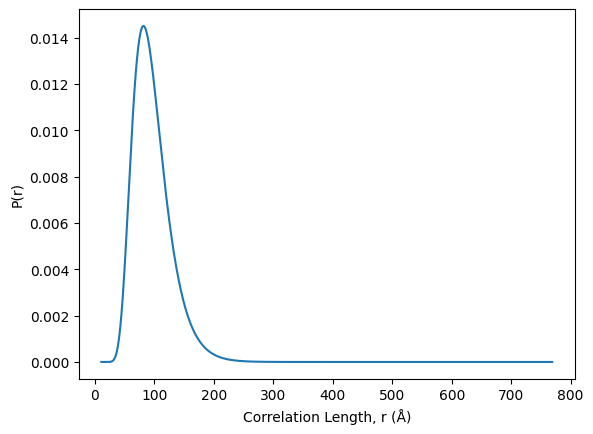

In [80]:
# Try with a synthetic data set to be sure it's working

import emtk
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

reload(emtk)

clength = 90.0 # correlation length in system

kappa = 1.0 / clength
curv = emtk.lorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])
curv.generateTestSamples(pvalues, xrange, 5000)

events = curv.data
lw = np.amin(events)
hi = np.amax(events)
slic = (hi-lw)/31
hbins = np.arange(lw,hi,slic)
hist = np.histogram(events, bins=hbins)
#print(hist)

xvals=hist[1]
rl = np.roll(hbins,-1)
xvals = 0.5*(hbins + rl)
xvals = np.delete(xvals,-1)
yvals=hist[0]

psf, rvals = lorentzianPSF(xvals, yvals)
#psf, rvals = spheresPSF(xvals, yvals)

#print("Noisy dimensions:", noisy.ndim, "and shape", noisy.shape)
#print("PSF dimensions:", psf.ndim, "and shape", psf.shape)

resto = LR_deconv(yvals, psf, niter=50)

fity = getfity(resto, psf)

dats = np.sum(yvals)
fits = np.sum(fity)
fity = fity * dats/fits

#print(resto)

fig, ax = plt.subplots()
ax.plot(rvals, resto)
ax.set_xlabel("Correlation Length, r (Å)")
ax.set_ylabel("P(r)")

1.0714545510888758


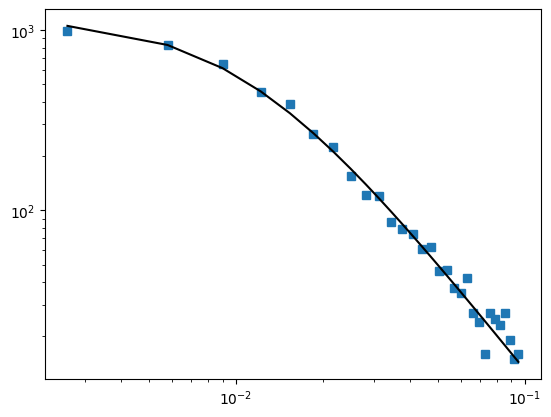

In [40]:
fig, ax = plt.subplots()
ax.plot(xvals, yvals, 's')
ax.plot(xvals, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

chisq = x2(yvals, fity)
print(chisq / xvals.size)

Generated 10000 samples using parameters [80.]
Lucy-Richardson fit failed to converge after 50 iterations.
x2= 3.0338898615047483


Text(0, 0.5, 'P(r)')

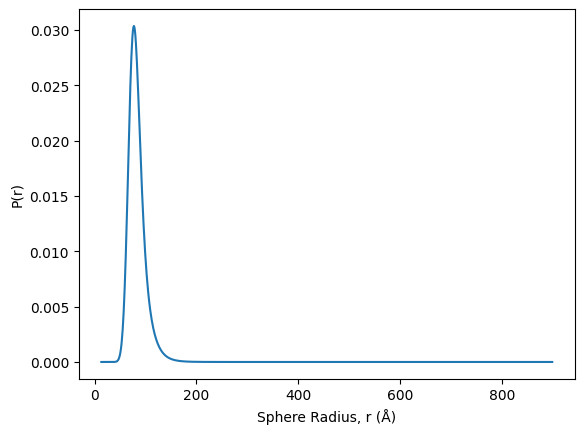

In [81]:
# Monodisperse hard sphere

# Try with a synthetic data set to be sure it's working

import emtk
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

reload(emtk)

curv = emtk.hardSphereCurve()
pvalues = np.array([80.0])
xrange = np.array([0.001, 0.1])
curv.generateTestSamples(pvalues, xrange, 10000)

events = curv.data
lw = np.amin(events)
hi = np.amax(events)
slic = (hi-lw)/31
hbins = np.arange(lw,hi,slic)
hist = np.histogram(events, bins=hbins)
#print(hist)

xvals=hist[1]
rl = np.roll(hbins,-1)
xvals = 0.5*(hbins + rl)
xvals = np.delete(xvals,-1)
yvals=hist[0]

#psf, rvals = lorentzianPSF(xvals, yvals)
psf, rvals = spheresPSF(xvals, yvals)

#print("Noisy dimensions:", noisy.ndim, "and shape", noisy.shape)
#print("PSF dimensions:", psf.ndim, "and shape", psf.shape)

resto = LR_deconv(yvals, psf, niter=50)

fity = getfity(resto, psf)

dats = np.sum(yvals)
fits = np.sum(fity)
fity = fity * dats/fits

#print(resto)

fig, ax = plt.subplots()
ax.plot(rvals, resto)
ax.set_xlabel("Sphere Radius, r (Å)")
ax.set_ylabel("P(r)")

3.9108536445415543


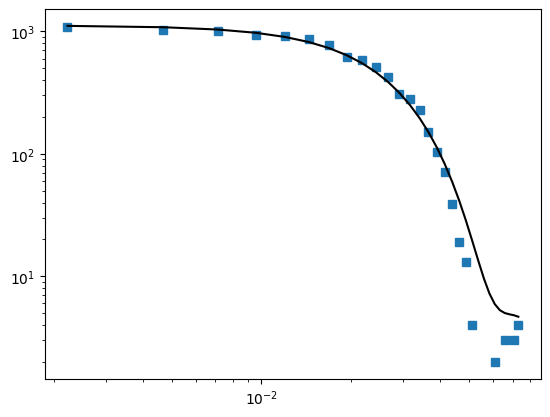

In [63]:
fig, ax = plt.subplots()
ax.plot(xvals, yvals, 's')
ax.plot(xvals, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

chisq = x2(yvals, fity)
print(chisq / xvals.size)

Generated 2500 samples using parameters [100.]
Generated 2500 samples using parameters [400.]
Lucy-Richardson fit failed to converge after 100 iterations.
x2= 6.103995258128009


Text(0, 0.5, 'P(r)')

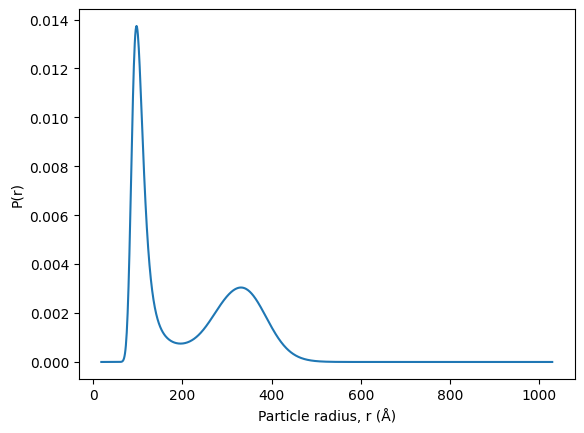

In [84]:
# Bimodal hard spheres

import emtk
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

reload(emtk)

pvalues = np.array([100.0])

curv = emtk.hardSphereCurve()
xrange = np.array([0.001, 0.1])
curv.generateTestSamples(pvalues, xrange, 2500)


pvalues = np.array([400.0])

curv2 = emtk.hardSphereCurve()
xrange = np.array([0.001, 0.1])
curv2.generateTestSamples(pvalues, xrange, 2500)

events = np.concatenate((curv.data, curv2.data), axis=None)
np.random.shuffle(events)

lw = np.amin(events)
hi = np.amax(events)
slic = (hi-lw)/31
hbins = np.arange(lw,hi,slic)
hist = np.histogram(events, bins=hbins)
#print(hist)

xvals=hist[1]
rl = np.roll(hbins,-1)
xvals = 0.5*(hbins + rl)
xvals = np.delete(xvals,-1)
yvals=hist[0]

#psf, rvals = lorentzianPSF(xvals, yvals)
psf, rvals = spheresPSF(xvals, yvals)

#print("Noisy dimensions:", noisy.ndim, "and shape", noisy.shape)
#print("PSF dimensions:", psf.ndim, "and shape", psf.shape)

resto = LR_deconv(yvals, psf)

fity = getfity(resto, psf)

dats = np.sum(yvals)
fits = np.sum(fity)
fity = fity * dats/fits

#print(resto)

fig, ax = plt.subplots()
ax.plot(rvals, resto)
ax.set_xlabel("Particle radius, r (Å)")
ax.set_ylabel("P(r)")

6.0831323294009865


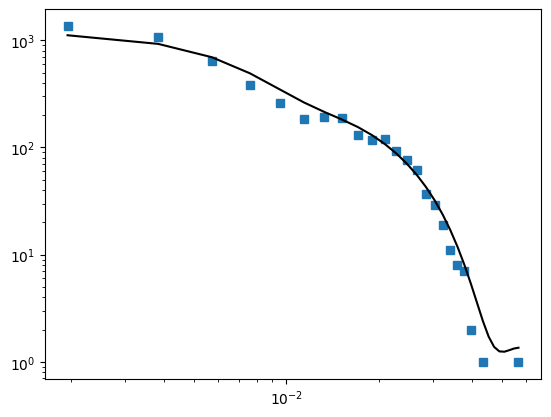

In [77]:
fig, ax = plt.subplots()
ax.plot(xvals, yvals, 's')
ax.plot(xvals, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

chisq = x2(yvals, fity)
print(chisq / xvals.size)

This is absolutely working.  The difference in resolution for the inverse problem is related to the difference in count rate at different Q values, impacting on the quality of the satistics.  For the small particles, we have 2 decades in delta-I, whilst for the large particles, we have less than 1 decade delta-I and fewer bins, so the estimated distribution is wider.